In [7]:
import librosa
import os
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct
from librosa.feature import mfcc
from IPython.display import Audio,display
import pandas as pd
import time
import soundfile as sf
import random
from librosa.feature import delta

In [8]:
audiopath=r"C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac"

In [4]:
def process_audio_file(file_path, target_sr=8000, silence_threshold=20):
    # Load the audio file at its original sample rate
    signal, original_sr = librosa.load(file_path, sr=None)
    
    # Downsample the audio to reduce the size
    signal_resampled = librosa.resample(signal, orig_sr=original_sr, target_sr=target_sr)
    
    # Trim silence from the beginning and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal_resampled, top_db=silence_threshold)
    
    # Save the processed file as a downsampled version
    output_file = file_path.replace('.flac', f'_processed_{target_sr}.flac')
    sf.write(output_file, trimmed_signal, target_sr)
    
    return output_file


def process_dataset(audiopath, target_sr=8000, num_samples=5000):
    # Get all audio files from the directory
    all_files = [os.path.join(audiopath, f) for f in os.listdir(audiopath) if f.endswith('.flac')]
    
    # Check if there are enough files and select the required number
    if len(all_files) < num_samples:
        print(f"Only {len(all_files)} files available. Processing all of them.")
        num_samples = len(all_files)
    
    # Subsample the dataset
    selected_files = random.sample(all_files, num_samples)
    
    # Process each selected file
    processed_files = []
    for file in selected_files:
        processed_file = process_audio_file(file, target_sr=target_sr)
        processed_files.append(processed_file)
        print(f"Processed and saved: {processed_file}")

    return processed_files

processed_files = process_dataset(audiopath, target_sr=8000, num_samples=5000)




Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_9091219_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_4552404_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_6722799_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_1085528_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_6906314_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_2611756_processed_8000_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_9262016_processed_8000.flac
Processed and saved: C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_2931007_processed_8000.flac
Processed and saved: C:\Users\vib

Playing: LA_E_9091219_processed_8000.flac


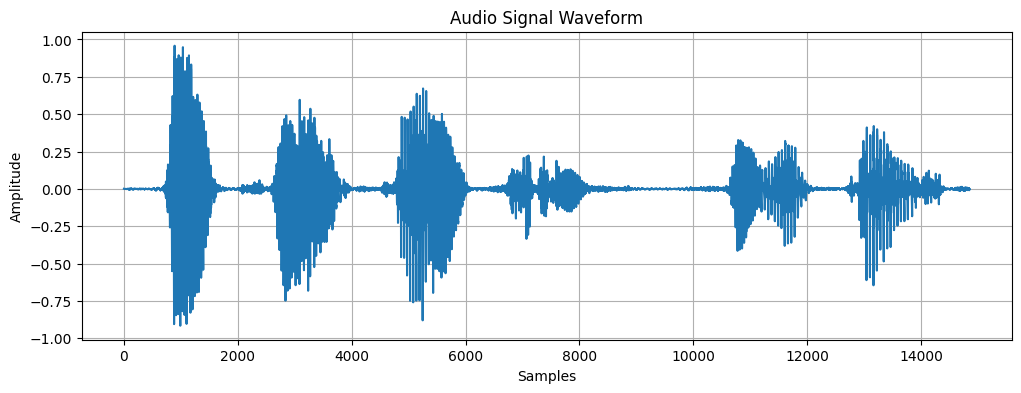

Playing: LA_E_4552404_processed_8000.flac


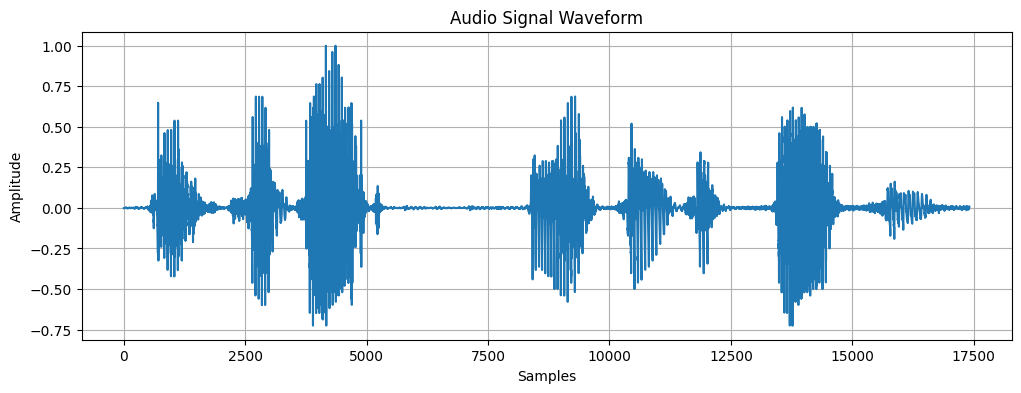

Playing: LA_E_6722799_processed_8000.flac


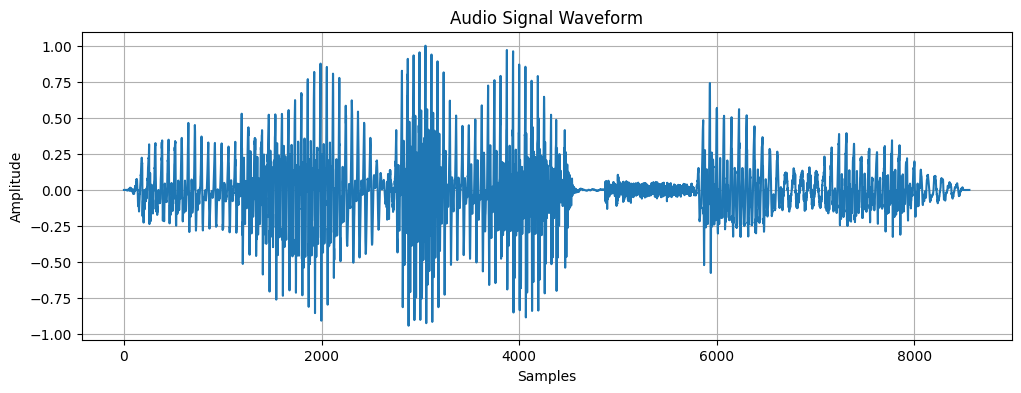

Finished playing selected audio files.


In [11]:
def plot_audio_waveform(signal, sr):
    """Plots the waveform of the audio signal."""
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title('Audio Signal Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

def load_and_play_audio(file_path):
    # Load the audio file using librosa
    signal, sr = librosa.load(file_path, sr=None)
    
    # Display the file name and play the audio
    print(f"Playing: {os.path.basename(file_path)}")
    plot_audio_waveform(signal, sr)
    display(Audio(data=signal, rate=sr))  # 'display' is used to play the audio
    time.sleep(3)# Limit the number of files to play for checking

files_to_play = processed_files[:3]  # Only play the first 3 processed files

# Play a few samples for checking
for file_path in files_to_play:
    load_and_play_audio(file_path)

print("Finished playing selected audio files.")





Sample Rate: 16000 Hz
Processed Signal Length: 16896 samples
Processed Signal (first 10 samples): [-0.00059132 -0.00062543 -0.00030172 -0.0002363  -0.00049281 -0.00066464
 -0.00059424 -0.00052087 -0.00057017 -0.00057979]


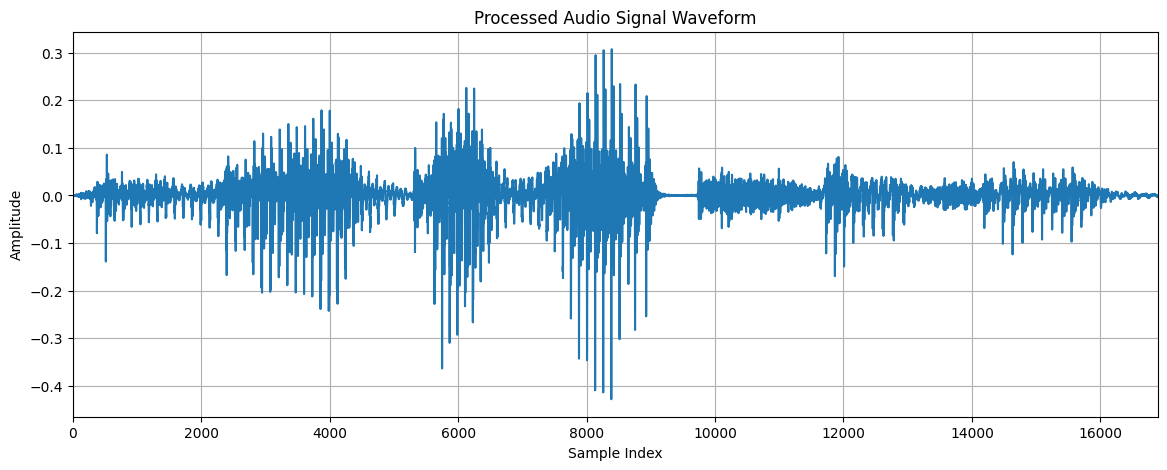

In [44]:
def spectral_subtraction(signal, noise_estimation_factor=0.1):
    """Apply spectral subtraction for noise reduction."""
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal)
    
    # Compute magnitude and phase
    magnitude, phase = np.abs(stft), np.angle(stft)
    
    # Estimate noise by taking the average magnitude spectrum
    noise_magnitude = np.mean(magnitude, axis=1, keepdims=True) * noise_estimation_factor
    
    # Subtract noise from magnitude
    magnitude_clean = np.maximum(magnitude - noise_magnitude, 0)
    
    # Reconstruct the signal from cleaned magnitude and original phase
    cleaned_stft = magnitude_clean * np.exp(1j * phase)
    cleaned_signal = librosa.istft(cleaned_stft)
    
    return cleaned_signal


def preprocess_audio(file_path, sr=16000):
    """Preprocess audio file by normalizing, applying a pre-emphasis filter, and removing silence."""
    # Load audio file
    signal, sr = librosa.load(file_path, sr=sr)
    
    # Normalize the audio signal
    signal = signal / np.max(np.abs(signal))

    # Pre-emphasis filter
    pre_emphasis = 0.97
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Remove silence
    signal, _ = librosa.effects.trim(signal)

    # Apply spectral subtraction for noise reduction
    cleaned_signal = spectral_subtraction(signal)

    # Print details about the processed audio
    print(f"Sample Rate: {sr} Hz")
    print(f"Processed Signal Length: {len(cleaned_signal)} samples")
    print(f"Processed Signal (first 10 samples): {cleaned_signal[:10]}")

    # Plot the processed audio signal waveform
    plt.figure(figsize=(14, 5))
    plt.plot(cleaned_signal)
    plt.title('Processed Audio Signal Waveform')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(cleaned_signal))
    plt.grid()
    plt.show()

    return cleaned_signal, sr

processed_signal, sample_rate = preprocess_audio(file_path)

def preprocess_audio_directory(path):
    """Process all audio files in a directory."""
    processed_signals = []
    sample_rates = []
    files_processed = []

    # Loop through each file in the directory
    for filename in os.listdir(path):
        if filename.endswith('.flac'):  # Change to .wav if needed
            file_path = os.path.join(path, filename)
            print(f"Processing {file_path}...")
            processed_signal, sample_rate = preprocess_audio(file_path)
            processed_signals.append(processed_signal)
            sample_rates.append(sample_rate)
            files_processed.append(file_path)

    return processed_signals, sample_rates, files_processed
# # Optionally play a few samples for checking
# files_to_play = files_processed[:3]

Processed sample 1/5
Processed sample 2/5
Processed sample 3/5
Processed sample 4/5
Processed sample 5/5
MFCCs shape: (79, 20)
Delta shape: (79, 20)
Double Delta shape: (79, 20)


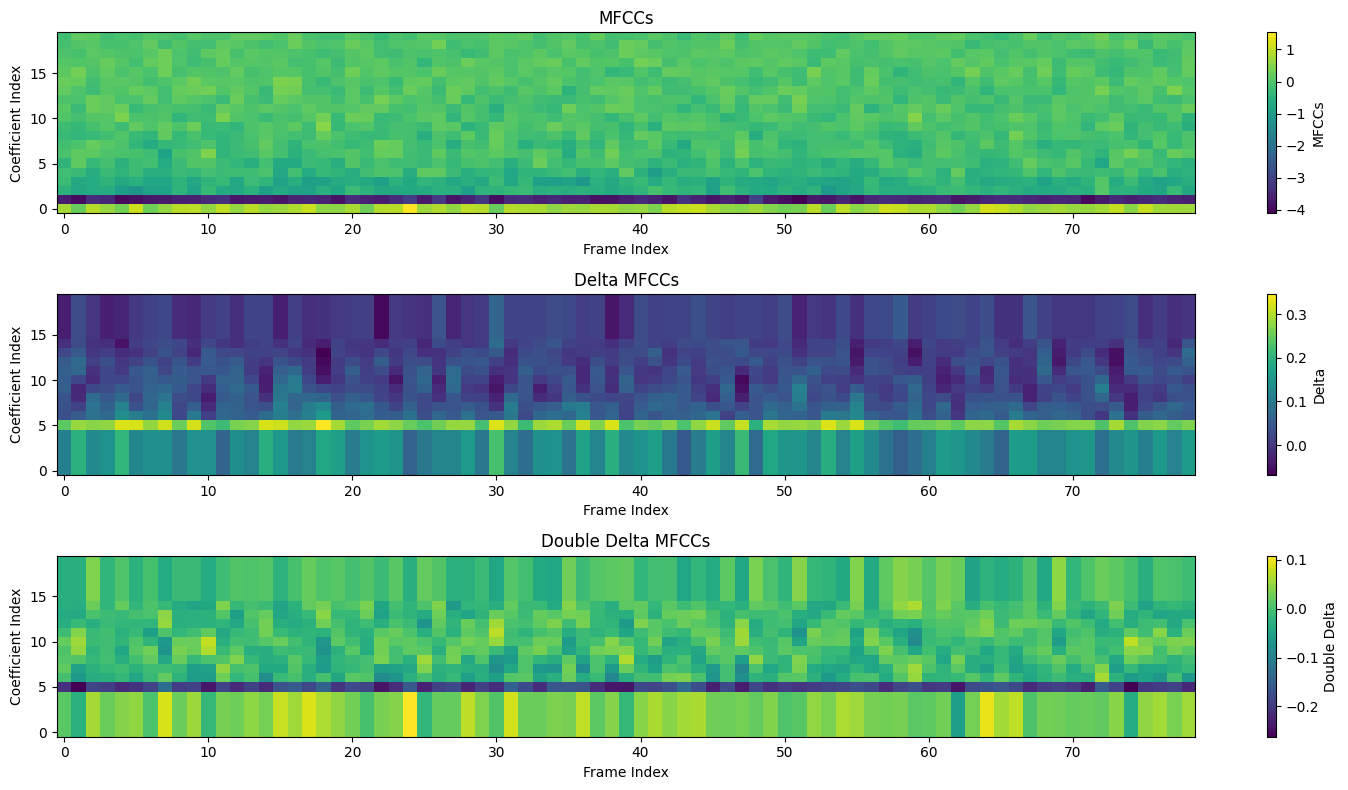

In [46]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    
    # Pre-emphasis filter to enhance high frequencies
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)  # Convert window length to samples
    hop_length = frame_length_in_samples // 2  # Overlap of 50%
    
    # Frame the speech signal
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    
    # Apply Hamming window to each frame
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Compute the magnitude spectrum
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2  # Magnitude squared
    
    # Keep only the first half of the spectrum
    fr_all = fr_all[:, :NFFT // 2 + 1]

    # Mel filter bank
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    
    # Apply the filter bank
    mel_spectrum = np.dot(fr_all, mel_filters.T)  # Apply the mel filter bank
    
    # Logarithmic scaling
    log_mel_spectrum = np.log10(mel_spectrum + np.finfo(float).eps)  # Avoid log(0)
    
    # Discrete Cosine Transform (DCT) to obtain MFCCs
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    # Calculate delta and double delta
    delta = librosa.feature.delta(mfccs)  # First derivative
    double_delta = librosa.feature.delta(mfccs, order=2)  # Second derivative
    
    

    return mfccs, delta, double_delta

def extract_mfcc_multiple(samples, Fs, Window_Length, NFFT, No_Filter):
    """Extract MFCCs from multiple audio samples."""
    all_mfccs = []
    all_delta = []
    all_double_delta = []

    for idx, speech in enumerate(samples):
        mfccs, delta, double_delta = extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter)
        all_mfccs.append(mfccs)
        all_delta.append(delta)
        all_double_delta.append(double_delta)
        print(f'Processed sample {idx + 1}/{len(samples)}')

    return all_mfccs, all_delta, all_double_delta

sr = 16000  # Sample rate
num_samples = 5  # Example: number of samples to create
samples = [np.random.randn(sr) for _ in range(num_samples)]  # Generate random noise as example audio

# Parameters for MFCC extraction
Window_Length = 25  # in milliseconds
NFFT = 512  # Number of FFT points
No_Filter = 20  # Number of Mel filter banks to use

# Extract MFCCs from multiple samples
all_mfccs, all_delta, all_double_delta = extract_mfcc_multiple(samples, sr, Window_Length, NFFT, No_Filter)

# Display the shapes of the extracted features
print(f'MFCCs shape: {mfccs.shape}')
print(f'Delta shape: {delta.shape}')
print(f'Double Delta shape: {double_delta.shape}')

def plot_features(mfccs, delta, double_delta):
    plt.figure(figsize=(15, 8))

    # Plot MFCCs
    plt.subplot(3, 1, 1)
    plt.imshow(mfccs.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='MFCCs')
    plt.title('MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    # Plot Delta
    plt.subplot(3, 1, 2)
    plt.imshow(delta.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Delta')
    plt.title('Delta MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    # Plot Double Delta
    plt.subplot(3, 1, 3)
    plt.imshow(double_delta.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Double Delta')
    plt.title('Double Delta MFCCs')
    plt.xlabel('Frame Index')
    plt.ylabel('Coefficient Index')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_features(mfccs, delta, double_delta)

In [47]:
def trimf(x, params):
    if len(params) != 3:
        raise ValueError("trimf requires params to be a list of 3 elements")
    a, b, c = params
    y = np.zeros_like(x)
    if a < b:
        index = (x > a) & (x < b)
        y[index] = (x[index] - a) / (b - a)
    if b < c:
        index = (x > b) & (x < c)
        y[index] = (c - x[index]) / (c - b)
    y[x == b] = 1.0
    return y

In [54]:
def deltas(features, N=3):
    
    if len(features.shape) == 1:
        features = features[:, np.newaxis]  # Ensure features are 2D
        
    num_frames, num_features = features.shape
    delta = np.zeros_like(features)

    # Precompute the weights
    weights = np.arange(1, N + 1)

    for t in range(num_frames):
        for i in range(num_features):
            if t < N:  # For the beginning frames
                delta[t, i] = np.sum(weights[:t + 1] * (features[min(t + N, num_frames - 1), i] - features[t, i])) / np.sum(weights[:t + 1])
            elif t >= num_frames - N:  # For the ending frames
                delta[t, i] = np.sum(weights[:num_frames - t] * (features[t, i] - features[max(t - N, 0), i])) / np.sum(weights[:num_frames - t])
            else:  # For the middle frames
                delta[t, i] = np.sum(weights * (features[t + N, i] - features[t - N, i])) / (2 * np.sum(weights))
    
    return delta

In [57]:
def extract_lfcc(samples, Fs, Window_Length, NFFT, No_Filter):
    """Extracts LFCCs, delta, and double delta from multiple speech signals."""
    
    all_stat = []
    all_delta = []
    all_double_delta = []

    for idx, speech in enumerate(samples):
        # Pre-emphasis
        speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
        
        # Framing and windowing
        frame_length_in_samples = int((Fs / 1000) * Window_Length)
        hop_length = frame_length_in_samples // 2
        framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
        w = np.hamming(frame_length_in_samples)
        y_framed = framedspeech * w
        
        # Frequency and filter bank
        f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
        filter_bandwidths = np.linspace(min(f), max(f), No_Filter + 2)
        fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
        fa_all = fr_all[:, :NFFT // 2 + 1]
        
        # Filter bank creation
        filterbank = np.zeros((NFFT // 2 + 1, No_Filter))
        for i in range(No_Filter):
            filterbank[:, i] = trimf(f, [filter_bandwidths[i], filter_bandwidths[i + 1], filter_bandwidths[i + 2]])
        
        filbanksum = np.dot(fa_all, filterbank)

        # Calculate static LFCC
        t = dct(np.log10(filbanksum + np.finfo(float).eps), type=2, axis=1, norm='ortho')[:, :No_Filter]
        stat = t.T
        delta = deltas(stat, 3).T
        double_delta_features = deltas(delta, 3).T

        # Store results for this sample
        all_stat.append(stat)
        all_delta.append(delta)
        all_double_delta.append(double_delta_features)
        
        print(f'Processed sample {idx + 1}/{len(samples)}')

    return all_stat, all_delta, all_double_delta

# Sample rate and parameters
sr = 16000  # Sample rate
num_samples = 5  # Example: number of samples to create
samples = [np.random.randn(sr) for _ in range(num_samples)]  # Generate random noise as example audio

# Parameters for LFCC extraction
Window_Length = 25  # in milliseconds
NFFT = 512  # Number of FFT points
No_Filter = 20  # Number of Mel filter banks to use

# Extract LFCCs from multiple samples
all_stat, all_delta, all_double_delta = extract_lfcc(samples, sr, Window_Length, NFFT, No_Filter)

# Display the shape of LFCCs for the first sample
print("Static LFCC shape for first sample:", all_stat[0].shape)
print("Delta LFCC shape for first sample:", all_delta[0].shape)
print("Double Delta LFCC shape for first sample:", all_double_delta[0].shape)

# Print the first 3 values for static LFCC, delta, and double delta of the first sample
print("Static LFCC (first 3 values) for first sample:", all_stat[0][:3])
print("Delta LFCC (first 3 values) for first sample:", all_delta[0][:3])
print("Double Delta LFCC (first 3 values) for first sample:", all_double_delta[0][:3])

Processed sample 1/5
Processed sample 2/5
Processed sample 3/5
Processed sample 4/5
Processed sample 5/5
Static LFCC shape for first sample: (20, 79)
Delta LFCC shape for first sample: (79, 20)
Double Delta LFCC shape for first sample: (20, 79)
Static LFCC (first 3 values) for first sample: [[14.47016025 14.99319187 14.6357642  14.99793335 15.15341036 14.82484098
  14.57227039 15.10120844 14.8040492  14.93119586 15.23188137 14.55801109
  14.74964873 14.6625074  15.10767311 14.90617308 14.87676944 14.99087271
  14.72461459 15.0828641  14.94664883 15.04677683 14.86396352 15.00508811
  14.70310601 14.6687372  14.86249928 14.96307812 14.81037344 14.80894476
  14.82907923 14.65209646 14.97183017 14.5609433  14.93623088 14.7638758
  14.94518205 14.92312002 14.98891993 14.95637757 14.85087154 14.81993749
  14.71226319 14.92723687 14.81726436 14.78719277 14.80810489 15.13850504
  14.97344956 14.79483048 14.71493304 14.59735487 14.78003079 15.01213591
  14.85219149 14.9300552  14.81855055 14.94

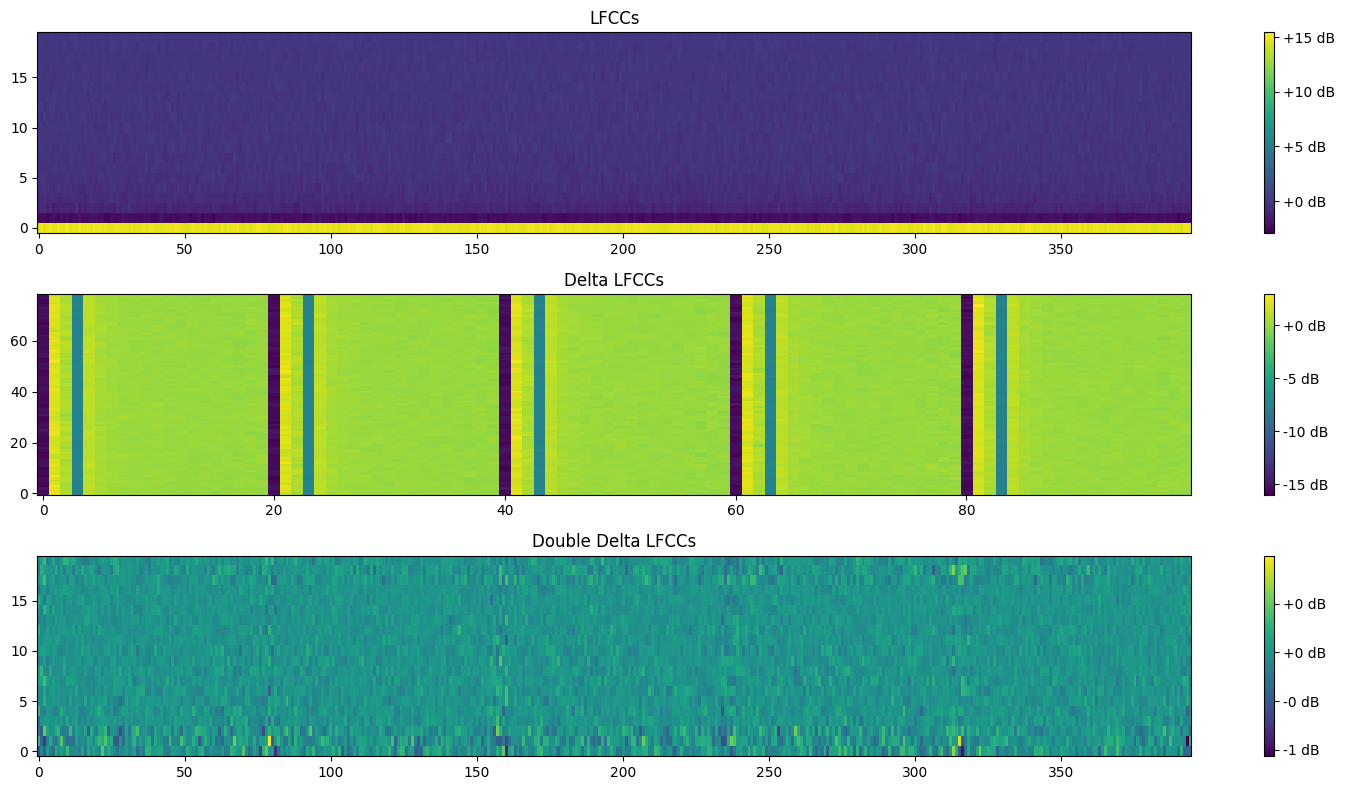

In [59]:
LFCCs_combined = np.concatenate(all_stat, axis=1)  # Concatenate along columns
Delta_LFCCs_combined = np.concatenate(all_delta, axis=1)
Double_Delta_LFCCs_combined = np.concatenate(all_double_delta, axis=1)

# Plotting
plt.figure(figsize=(15, 8))

# LFCCs
plt.subplot(3, 1, 1)
plt.imshow(LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('LFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta LFCCs
plt.subplot(3, 1, 2)
plt.imshow(Delta_LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta LFCCs
plt.subplot(3, 1, 3)
plt.imshow(Double_Delta_LFCCs_combined, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

Processed sample 1/1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.810758690096296..8.009065673396693].


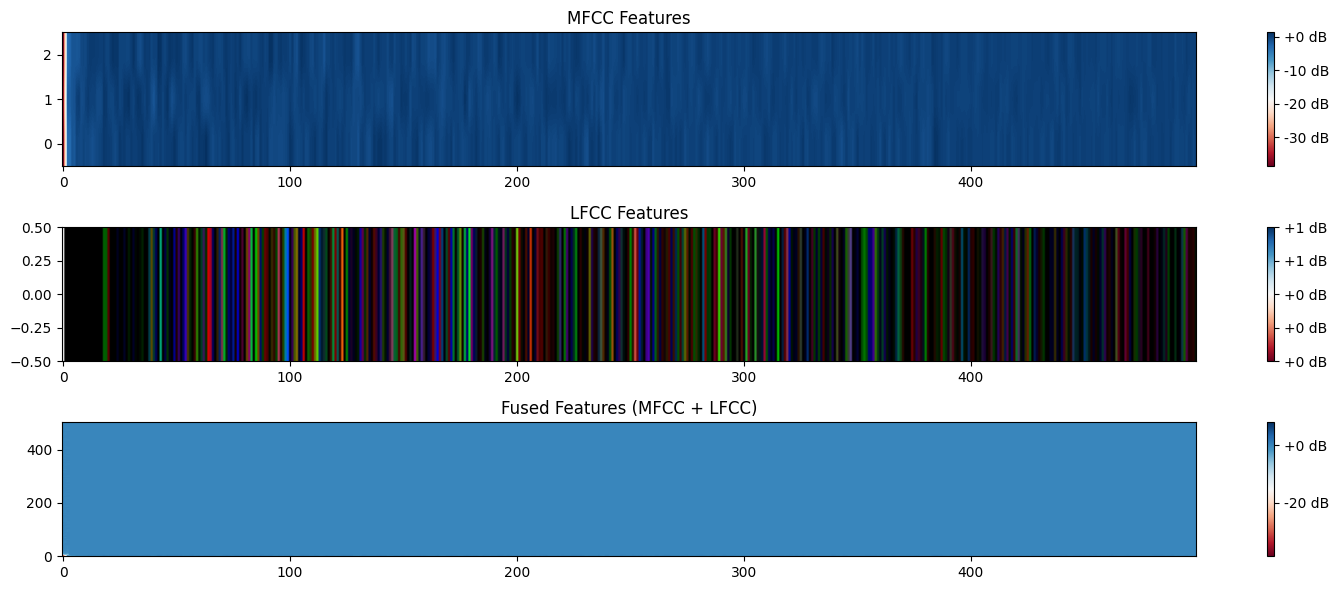

Combined features saved to combined_features.csv


In [69]:
signal = np.random.rand(5 * 22050)  # Simulated audio signal (5 seconds)
sr = 22050  # Sample rate
Window_Length = 2048  # Window length for STFT in samples
NFFT = 2048  # Number of FFT points
No_Filter = 500

def fuse_features(mfccs, lfccs):
    """Fuse MFCC and LFCC features, handle frame padding and save to CSV."""

    mfccs = np.array(mfccs)
    lfccs = np.array(lfccs)

    if mfccs.ndim == 3 and mfccs.shape[0] == 1:
        mfccs = np.squeeze(mfccs, axis=0)  # Remove single extra dimension
    if lfccs.ndim == 3 and lfccs.shape[0] == 1:
        lfccs = np.squeeze(lfccs, axis=0)  # Remove single extra dimension
    
    # Now both mfccs and lfccs should be 2D
    if mfccs.ndim != 2 or lfccs.ndim != 2:
        print("Both MFCC and LFCC must be 2D arrays for fusion.")
        return None, None

    if mfccs.size == 0 or lfccs.size == 0:
        print("One of the features is empty. Cannot fuse.")
        return None, None

    # Get the number of frames for both MFCC and LFCC
    mfcc_frames = mfccs.shape[1]  # number of frames
    lfcc_frames = lfccs.shape[1]

    if mfcc_frames < lfcc_frames:
        padding = np.zeros((mfccs.shape[0], lfcc_frames - mfcc_frames))  # Pad MFCCs
        mfccs = np.hstack([mfccs, padding])
    elif lfcc_frames < mfcc_frames:
        padding = np.zeros((lfccs.shape[0], mfcc_frames - lfcc_frames))  # Pad LFCCs
        lfccs = np.hstack([lfccs, padding])

    # Fuse features along the coefficient axis (vertical stacking)
    combined_features = np.concatenate((mfccs, lfccs), axis=0)

    # Create DataFrame and save to CSV
    combined_df = pd.DataFrame(combined_features.T)  # Transpose to match rows/columns
    csv_file_path = 'combined_features.csv'  # Change this path as needed
    combined_df.to_csv(csv_file_path, index=False)
    
    return combined_features, csv_file_path

def plot_features(mfccs, lfccs, fused_features):
    """Plot MFCC, LFCC, and fused features using matplotlib."""
    plt.figure(figsize=(15, 6))

    # Plot MFCCs
    plt.subplot(3, 1, 1)
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('MFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot LFCCs
    plt.subplot(3, 1, 2)
    plt.imshow(lfccs, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('LFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot Fused Features
    plt.subplot(3, 1, 3)
    plt.imshow(fused_features, aspect='auto', origin='lower', cmap='RdBu')
    plt.title('Fused Features (MFCC + LFCC)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Feature extraction and plotting
mfccs, _, _ = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)

# Wrap `signal` in a list to match the expected input type for LFCC extraction
lfccs, _, _ = extract_lfcc([signal], sr, Window_Length, NFFT, No_Filter)

# Fuse MFCC and LFCC features
fused_features, csv_file_path = fuse_features(mfccs, lfccs)

if len(mfccs) > 0 and len(lfccs) > 0:
    # Plot the features
    plot_features(mfccs, lfccs, fused_features)

    print(f"Combined features saved to {csv_file_path}")
